<a href="https://colab.research.google.com/github/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/blob/main/notebooks/04_RNN_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Entrenamiento, Predicción y Evaluación de un modelo RNN

#### **Importación de Datos**

In [ ]:
import requests
import pandas as pd
import numpy as np
import sys, os, math, typing as t
import warnings
import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from io import BytesIO
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from datetime import timedelta

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras import callbacks, layers, regularizers, mixed_precision

plt.rcParams.update({
    "figure.figsize": (12, 5),
    "axes.grid": True
})

warnings.filterwarnings('ignore')

tf.keras.utils.set_random_seed(42)
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
# Importar datos
DATA_GITHUB_URL = 'https://raw.githubusercontent.com/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/refs/heads/main/data/zone1_power_consumption_of_tetouan_city.csv'

# Descargar los datos desde github
response = requests.get(DATA_GITHUB_URL)

# Convertir en un df desde el xlsx de github
df = pd.read_csv(BytesIO(response.content), sep=',')

df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df = df.set_index("datetime")

# Validaciones mínimas
expected_cols = {"temperature","humidity","general_diffuse_flows","zone_1"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Faltan columnas en el dataset: {missing}. "
                     f"Columnas disponibles: {df.columns.tolist()}")

print("\nFrecuencia aproximada:", (df.index.to_series().diff().mode().iloc[0]))
print("Filas totales:", len(df))


Frecuencia aproximada: 0 days 00:10:00
Filas totales: 52416


#### **Definición de Funciones y Partición de los datos**

In [ ]:
from typing import Optional, Dict

def temporal_split(df: pd.DataFrame, train_size=0.7, val_size=0.2):
    """Split temporal 70/20/10 por defecto."""
    n = len(df)
    n_train = int(n * train_size)
    n_val = int(n * val_size)
    train = df.iloc[:n_train]
    val = df.iloc[n_train:n_train+n_val]
    test = df.iloc[n_train+n_val:]
    return train, val, test

def make_windows(
    data: pd.DataFrame,
    target_col: str,
    feature_cols: t.List[str],
    history: int = 1008,   # 7 días de 10-min
    target_shift: int = 1   # 1 paso adelante
):
    """Crea X, y con ventana deslizante. X tiene forma (N, history, F).
    Para modelos tipo sklearn, se devuelve además X2 (aplanado)."""
    feats = data[feature_cols].values
    target = data[target_col].values
    X, y = [], []
    for i in range(len(data) - history - target_shift + 1):
        X.append(feats[i:i+history])
        y.append(target[i+history+target_shift-1])
    X = np.array(X)
    y = np.array(y)
    # Aplanado para modelos de tabular (árboles, etc.)
    ns, h, f = X.shape
    X2 = X.reshape((ns, h*f))
    return X, X2, y

def smape(y_true, y_pred, eps: float = 1e-8):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100.0

def wape(y_true, y_pred, eps: float = 1e-8):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return (np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + eps)) * 100.0

@dataclass
class Scalers:
    X: Optional[StandardScaler] = None
    y: Optional[StandardScaler] = None

def fit_scalers(train_df: pd.DataFrame, feature_cols: t.List[str], target_col: str) -> Scalers:
    sx = StandardScaler()
    sy = StandardScaler()
    sx.fit(train_df[feature_cols])
    sy.fit(train_df[[target_col]])
    return Scalers(X=sx, y=sy)

def apply_scalers(df: pd.DataFrame, scalers: Scalers, feature_cols: t.List[str], target_col: str):
    out = df.copy()
    out[feature_cols] = scalers.X.transform(out[feature_cols])
    out[target_col]  = scalers.y.transform(out[[target_col]])
    return out

def inverse_target(y: np.ndarray, scalers: Scalers) -> np.ndarray:
    return scalers.y.inverse_transform(y.reshape(-1,1)).ravel()

def plot_segment(idx, y_true, y_pred, title="Predicción (tramo)", target_name="target"):
    plt.figure(figsize=(12,4))
    plt.plot(idx, y_true, label="Real", linewidth=2)
    plt.plot(idx, y_pred, label="Pred", linewidth=2)
    plt.title(title)
    plt.xlabel("Tiempo"); plt.ylabel(target_name); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
TARGET_COL = "zone_1"  # consumo a pronosticar
EXOG_COLS = ["temperature", "humidity", "general_diffuse_flows"]  # exógenas priorizadas

# Ordenar columnas por claridad (target al final)
cols = EXOG_COLS + [TARGET_COL]
df2 = df[cols].copy().astype("float32")

# Splits temporales base (para val/test)
train_df_full, val_df, test_df = temporal_split(df2, train_size=0.7, val_size=0.2)
print({s: len(x) for s,x in [('train_full',train_df_full),('val',val_df),('test',test_df)]})

# Entrenar con los últimos 45 días
POINTS_PER_DAY = 24 * 6           # 10 min = 6 puntos por hora = 144 por día
TRAIN_DAYS = 45
WINDOW_TRAIN_POINTS = TRAIN_DAYS * POINTS_PER_DAY  # 45 * 144 = 6480

HISTORY_WINDOW = 7 * POINTS_PER_DAY   # 7 días = 1008 pasos
SHIFT_ONE_STEP = 1                    # +10 min

# Tomamos exactamente los últimos 45 días como training
train_df = train_df_full.tail(WINDOW_TRAIN_POINTS)

print(
    "train_df (últimos 45 días) =",
    train_df.index.min(), "→", train_df.index.max(),
    "| filas:", len(train_df)
)

# Escalado Z-score (stats SOLO del train de 45 días)
scalers = fit_scalers(train_df, EXOG_COLS, TARGET_COL)
train_n = apply_scalers(train_df, scalers, EXOG_COLS, TARGET_COL)
val_n   = apply_scalers(val_df,   scalers, EXOG_COLS, TARGET_COL)
test_n  = apply_scalers(test_df,  scalers, EXOG_COLS, TARGET_COL)

# Ventanas one-step (history=1008, shift=1)
Xtr, Xtr2, ytr = make_windows(
    train_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)
Xva, Xva2, yva = make_windows(
    val_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)
Xte, Xte2, yte = make_windows(
    test_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)

print("Shapes →",
      "Xtr2:", Xtr2.shape, "ytr:", ytr.shape, "|",
      "Xva2:", Xva2.shape, "yva:", yva.shape, "|",
      "Xte2:", Xte2.shape, "yte:", yte.shape)

# Validación rápida
assert Xtr2.shape[0] >= 1, "No hay suficientes filas en los últimos 45 días para formar al menos 1 ventana."

{'train_full': 36691, 'val': 10483, 'test': 5242}
train_df (últimos 45 días) = 2017-07-29 19:10:00 → 2017-09-12 19:00:00 | filas: 6480
Shapes → Xtr2: (5472, 4032) ytr: (5472,) | Xva2: (9475, 4032) yva: (9475,) | Xte2: (4234, 4032) yte: (4234,)


#### **Entrenamiento**

In [ ]:
# Asegurar dtypes livianos
Xtr = Xtr.astype("float32"); ytr = ytr.astype("float32")
Xva = Xva.astype("float32"); yva = yva.astype("float32")
Xte = Xte.astype("float32"); yte = yte.astype("float32")

In [ ]:
rnn = Sequential([
    SimpleRNN(32, return_sequences=False, dtype="float32"),
    Dense(1, dtype="float32")  # predicción de t+1 (escala normalizada)
])

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)

rnn.compile(
    optimizer=opt,
    loss="mse",          # trabajamos en escala normalizada
    metrics=["mae"]
)

cbs = [
    callbacks.EarlyStopping(
        monitor="val_loss", mode="min",
        patience=5, min_delta=3e-4,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss", mode="min",
        factor=0.5,
        patience=2,           # baja LR rápido si entra en meseta
        min_delta=3e-4,       # coherente con EarlyStopping
        min_lr=1e-5,
        verbose=1
    ),
]

In [ ]:
start = time.time()
hist = rnn.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=200,
    batch_size=512,
    verbose=2,
    callbacks=cbs
)
end = time.time()
training_time = end - start
print("Tiempo de entrenamiento:", training_time)

Epoch 1/200
11/11 - 5s - 444ms/step - loss: 0.0057 - mae: 0.0522 - val_loss: 0.0087 - val_mae: 0.0615 - learning_rate: 1.0000e-03
Epoch 2/200
11/11 - 5s - 471ms/step - loss: 0.0049 - mae: 0.0461 - val_loss: 0.0088 - val_mae: 0.0622 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
11/11 - 5s - 420ms/step - loss: 0.0047 - mae: 0.0445 - val_loss: 0.0085 - val_mae: 0.0604 - learning_rate: 1.0000e-03
Epoch 4/200
11/11 - 4s - 394ms/step - loss: 0.0046 - mae: 0.0435 - val_loss: 0.0084 - val_mae: 0.0599 - learning_rate: 5.0000e-04
Epoch 5/200
11/11 - 4s - 334ms/step - loss: 0.0045 - mae: 0.0432 - val_loss: 0.0083 - val_mae: 0.0597 - learning_rate: 5.0000e-04
Epoch 6/200

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
11/11 - 3s - 254ms/step - loss: 0.0045 - mae: 0.0429 - val_loss: 0.0082 - val_mae: 0.0594 - learning_rate: 5.0000e-04
Epoch 7/200
11/11 - 3s - 264ms/step - loss: 0.0044 - mae: 0.0426 -

---

#### **Predicción**

A un paso

In [ ]:
# EVALUACIÓN ONE-STEP (VAL/TEST) — escala real

# Predicciones (escala normalizada)
y_pred_val_rnn = rnn.predict(Xva, batch_size=512, verbose=0).reshape(-1)
y_pred_te_rnn  = rnn.predict(Xte, batch_size=512, verbose=0).reshape(-1)

# Desnormalización
y_val_inv_rnn      = inverse_target(yva, scalers)
y_pred_val_inv_rnn = inverse_target(y_pred_val_rnn, scalers)
y_te_inv_rnn       = inverse_target(yte, scalers)
y_pred_te_inv_rnn  = inverse_target(y_pred_te_rnn, scalers)

# Métricas
smape_val_rnn = smape(y_val_inv_rnn, y_pred_val_inv_rnn)
wape_val_rnn  = wape(y_val_inv_rnn, y_pred_val_inv_rnn)
smape_te_rnn  = smape(y_te_inv_rnn,  y_pred_te_inv_rnn)
wape_te_rnn   = wape(y_te_inv_rnn,   y_pred_te_inv_rnn)

print(f"[RNN] ONE-STEP → VAL  sMAPE: {smape_val_rnn:.3f}% | WAPE: {wape_val_rnn:.3f}%")
print(f"[RNN] ONE-STEP → TEST sMAPE: {smape_te_rnn:.3f}% | WAPE: {wape_te_rnn:.3f}%")
print(f"[RNN] Entrenamiento: {training_time:.2f} segundos")

[RNN] ONE-STEP → VAL  sMAPE: 1.394% | WAPE: 1.348%
[RNN] ONE-STEP → TEST sMAPE: 3.430% | WAPE: 3.497%
[RNN] Entrenamiento: 40.98 segundos


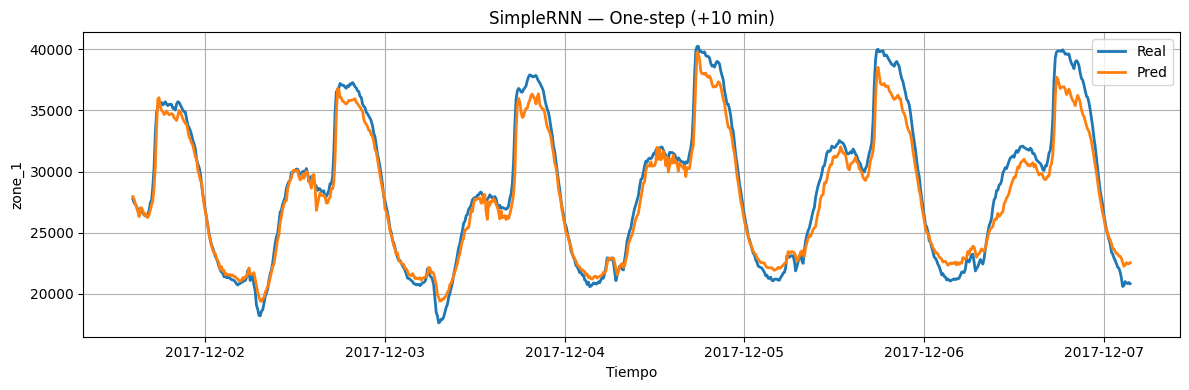

In [ ]:
start_idx = HISTORY_WINDOW + SHIFT_ONE_STEP - 1
idx_seg_rnn = test_df.index[start_idx : start_idx + len(y_te_inv_rnn)]

plot_segment(
    idx_seg_rnn[:800],
    y_te_inv_rnn[:800],
    y_pred_te_inv_rnn[:800],
    title="SimpleRNN — One-step (+10 min)",
    target_name=TARGET_COL
)

Con el modelo SimpleRNN en one‑step (+10 min) se observa un desempeño bueno: el modelo sigue con buena precisión los patrones diarios de consumo, logra capturar la mayoría de los picos y valles, aunque con cierta subestimación en los picos más altos. Este desempeño se confirma en sus métricas de one‑step test (sMAPE 3.430% y WAPE 3.497%)

A múltiples pasos

[RNN] RECURSIVE (3h) → TEST sMAPE: 26.196% | WAPE: 23.041%


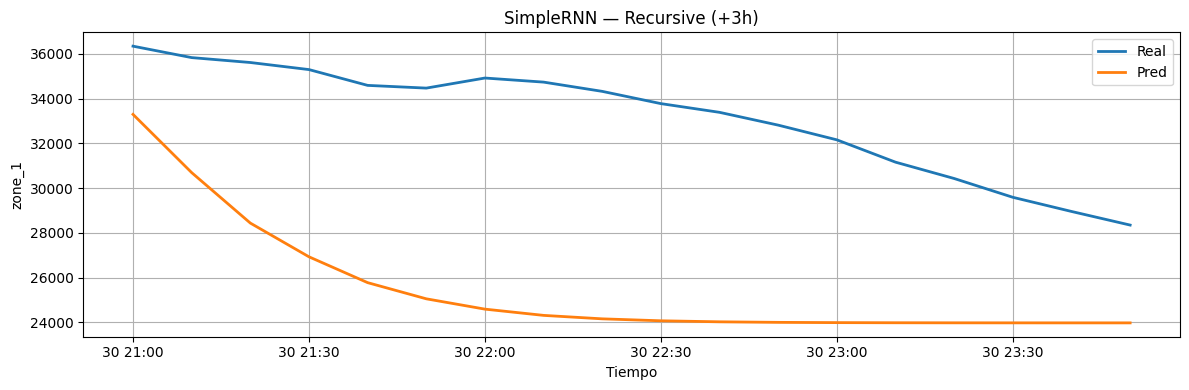

In [ ]:
STEPS = 18
feats_order = EXOG_COLS + [TARGET_COL]  # target último para poder actualizarlo

def recursive_forecast_seq(
    model,
    seed_window: np.ndarray,           # (HISTORY_WINDOW, F) normalizado
    steps: int,
    exog_future: np.ndarray | None = None  # opcional: (steps, len(EXOG_COLS)) normalizado
) -> np.ndarray:
    """Autoregresivo: usa la salida como último lag; exógenas en hold (o exog_future)."""
    hist = seed_window.astype("float32").copy()
    preds = []
    for i in range(steps):
        x = hist[np.newaxis, :, :]                 # (1, H, F)
        y_hat = model.predict(x, verbose=0)[0, 0]  # escalar normalizado
        preds.append(y_hat)
        # construir nueva fila
        next_row = hist[-1].copy()
        if exog_future is not None:
            next_row[:-1] = exog_future[i]
        next_row[-1] = y_hat
        hist = np.vstack([hist[1:], next_row])
    return np.array(preds, dtype="float32")

# Semilla al final del TEST dejando espacio para STEPS futuros
seed_start = max(0, len(test_n) - (HISTORY_WINDOW + STEPS))
seed_end   = seed_start + HISTORY_WINDOW
seed_win   = test_n[feats_order].values[seed_start:seed_end]  # (1008, F) normalizado

# Predicción recursiva (normalizada) y desnormalización
y_pred_rec_norm_rnn = recursive_forecast_seq(rnn, seed_win, STEPS)
y_pred_rec_rnn      = inverse_target(y_pred_rec_norm_rnn, scalers)

# Verdaderos y eje temporal
true_start = seed_end
true_end   = seed_end + STEPS
y_true_rec = test_df[TARGET_COL].values[true_start:true_end]
idx_future = test_df.index[true_start:true_end]

# Métricas multi-step recursive (escala real)
smape_rec_rnn = smape(y_true_rec, y_pred_rec_rnn)
wape_rec_rnn  = wape(y_true_rec, y_pred_rec_rnn)
print(f"[RNN] RECURSIVE (3h) → TEST sMAPE: {smape_rec_rnn:.3f}% | WAPE: {wape_rec_rnn:.3f}%")

# Plot recursive (+3h)
plot_segment(
    idx_future, y_true_rec, y_pred_rec_rnn,
    title="SimpleRNN — Recursive (+3h)",
    target_name=TARGET_COL
)

La gráfica del pronóstico recursivo a 3 horas muestra una degradación muy marcada. El modelo tiende a una caída rápida y exagerada, hasta estancarse en un valor bajo que se desvía claramente de la serie real. Este colapso predictivo explica sus métricas recursivas malas (sMAPE 26.196% y WAPE 23.041%).

---

#### **Análisis de Métricas**

El SimpleRNN, con un tiempo de entrenamiento de 40.98 segundos, mostró un desempeño razonable en el pronóstico inmediato: en el escenario one‑step (10 min) alcanzó métricas aceptables (sMAPE 3.430% y WAPE 3.497%), siguiendo de forma adecuada los ciclos de consumo energético aunque con ligera subestimación en los picos más altos. Sin embargo, en el horizonte recursivo de 3h su rendimiento se degradó fuertemente (sMAPE 26.196% y WAPE 23.041%), reflejando una clara divergencia respecto a la serie real y evidenciando problemas de acumulación de error. En el contexto del consumo de energía, esto implica que el SimpleRNN puede ser útil para predicciones de muy corto plazo, pero carece de la estabilidad necesaria para escenarios de varias horas, donde su sesgo acumulativo lo convierte en una opción poco confiable

#### **Referencias**

- Elman (1990), Finding Structure in Time (RNNs con memoria contextual). ([arXiv](https://arxiv.org/abs/1706.09516))
- Jordan (1997), Serial Order: A Parallel Distributed Processing Approach (arquitectura Jordan). ([catboost.ai](https://catboost.ai/docs/en/concepts/python-reference_catboostregressor))
- Keras — SimpleRNN (API y consideraciones prácticas). ([catboost.ai](https://catboost.ai/docs/en/features/training-on-gpu))